In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


CSV_PATH = "C:/taro/1차_프로젝트/통합데이터/SUWON_S_DATA_TABLE.csv"


# =========================================================
# 1) 데이터 로드 + 일별 집계
# =========================================================
def load_and_make_daily(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    # 날짜 변환 (TA_YMD: 20250628 형태)
    df["TA_YMD"] = pd.to_datetime(df["TA_YMD"].astype(str), format="%Y%m%d", errors="coerce")
    df = df.dropna(subset=["TA_YMD"])

    # 일별 집계: UNIT 합계, TEMP/RAIN 평균
    daily = (
        df.groupby("TA_YMD", as_index=False)
          .agg(
              UNIT=("UNIT", "sum"),
              TEMP=("TEMP", "mean"),
              RAIN=("RAIN", "mean")
          )
          .sort_values("TA_YMD")
          .reset_index(drop=True)
    )
    return daily


# =========================================================
# 2) 상관관계 계산 + 시각화
# =========================================================
def corr_and_plots(daily: pd.DataFrame) -> None:
    pear_temp = daily["UNIT"].corr(daily["TEMP"], method="pearson")
    spear_temp = daily["UNIT"].corr(daily["TEMP"], method="spearman")
    pear_rain = daily["UNIT"].corr(daily["RAIN"], method="pearson")
    spear_rain = daily["UNIT"].corr(daily["RAIN"], method="spearman")

    print("==== Correlation (Daily) ====")
    print(f"TEMP vs UNIT  | Pearson r = {pear_temp:.4f} | Spearman ρ = {spear_temp:.4f}")
    print(f"RAIN vs UNIT  | Pearson r = {pear_rain:.4f} | Spearman ρ = {spear_rain:.4f}")

    # 산점도 + 추세선
    def scatter_with_trend(x, y, xlab, title):
        plt.figure(figsize=(7, 4.8))
        plt.scatter(x, y, alpha=0.5, s=15)
        # 추세선(1차)
        m, b = np.polyfit(x, y, 1)
        xx = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        plt.plot(xx, m * xx + b, linewidth=2)
        plt.xlabel(xlab)
        plt.ylabel("UNIT (daily sum)")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    scatter_with_trend(
        daily["TEMP"].values, daily["UNIT"].values,
        "TEMP (daily mean)",
        f"UNIT vs TEMP (Pearson r={pear_temp:.3f}, Spearman ρ={spear_temp:.3f})"
    )

    scatter_with_trend(
        daily["RAIN"].values, daily["UNIT"].values,
        "RAIN (daily mean)",
        f"UNIT vs RAIN (Pearson r={pear_rain:.3f}, Spearman ρ={spear_rain:.3f})"
    )


# =========================================================
# 3) 날짜 기반 feature + (평년) TEMP/RAIN 추정치 만들기
#    -> "날짜만 입력"해도 예측 가능
# =========================================================
def add_calendar_features(daily: pd.DataFrame) -> pd.DataFrame:
    d = daily.copy()
    dt = d["TA_YMD"]

    d["dow"] = dt.dt.dayofweek              # 0=월 ~ 6=일
    d["month"] = dt.dt.month
    d["day"] = dt.dt.day
    d["weekofyear"] = dt.dt.isocalendar().week.astype(int)
    d["is_weekend"] = (d["dow"] >= 5).astype(int)

    # 연중 주기(계절성) sin/cos
    doy = dt.dt.dayofyear
    d["doy"] = doy
    d["doy_sin"] = np.sin(2 * np.pi * doy / 365.25)
    d["doy_cos"] = np.cos(2 * np.pi * doy / 365.25)
    return d


def build_climatology(d: pd.DataFrame) -> pd.DataFrame:
    """
    day-of-year(1~366)별 평균 TEMP/RAIN을 계산 -> 미래 날짜에서도 TEMP/RAIN을 '평년치'로 추정 가능
    """
    clim = d.groupby("doy")[["TEMP", "RAIN"]].mean()
    return clim


def estimate_temp_rain_by_date(target_date: pd.Timestamp, clim: pd.DataFrame) -> tuple[float, float]:
    doy = int(target_date.dayofyear)
    # 데이터가 365일만 있거나 366일이 없을 수도 있어서 fallback 처리
    if doy in clim.index:
        row = clim.loc[doy]
        return float(row["TEMP"]), float(row["RAIN"])

    # fallback: 가장 가까운 doy
    nearest = clim.index[np.argmin(np.abs(clim.index.values - doy))]
    row = clim.loc[nearest]
    return float(row["TEMP"]), float(row["RAIN"])


# =========================================================
# 4) 모델 학습(ML/DL) + 평가(시계열 holdout)
# =========================================================
def train_models(d: pd.DataFrame):
    # 학습에 쓸 feature (날짜 + TEMP/RAIN)
    feature_cols = [
        "dow", "month", "day", "weekofyear", "is_weekend",
        "doy_sin", "doy_cos",
        "TEMP", "RAIN"
    ]

    data = d.dropna(subset=feature_cols + ["UNIT"]).sort_values("TA_YMD").reset_index(drop=True)

    # 시계열 holdout: 마지막 20%를 테스트로
    split = int(len(data) * 0.8)
    train = data.iloc[:split]
    test = data.iloc[split:]

    X_train, y_train = train[feature_cols], train["UNIT"]
    X_test, y_test = test[feature_cols], test["UNIT"]

    # (1) 머신러닝 모델
    ml = HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=6,
        max_iter=300,
        random_state=42
    )
    ml.fit(X_train, y_train)
    pred_ml = ml.predict(X_test)

    # (2) 딥러닝(신경망) 모델: MLPRegressor (표준화 + 신경망)
    dl = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            alpha=1e-4,
            learning_rate_init=1e-3,
            max_iter=1500,
            early_stopping=True,
            random_state=42
        ))
    ])
    dl.fit(X_train, y_train)
    pred_dl = dl.predict(X_test)

    def metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        return mae, rmse

    ml_mae, ml_rmse = metrics(y_test, pred_ml)
    dl_mae, dl_rmse = metrics(y_test, pred_dl)

    print("\n==== Holdout Evaluation (last 20%) ====")
    print(f"[ML] MAE={ml_mae:,.2f} | RMSE={ml_rmse:,.2f}")
    print(f"[DL] MAE={dl_mae:,.2f} | RMSE={dl_rmse:,.2f}")

    return ml, dl, feature_cols, data


# =========================================================
# 5) 날짜 입력 -> UNIT 예측 함수
#    - 과거 날짜면: 실제 TEMP/RAIN 있으면 그걸 사용
#    - 미래/없는 날짜면: climatology로 TEMP/RAIN 추정해서 사용
# =========================================================
def build_predictor(data_with_features: pd.DataFrame, clim: pd.DataFrame, ml_model, dl_model, feature_cols):
    # 과거 날짜 lookup (실제 TEMP/RAIN이 있는 날짜면 사용)
    lookup = data_with_features.set_index("TA_YMD")[["TEMP", "RAIN"]].to_dict(orient="index")

    def make_one_row(target_date: pd.Timestamp) -> pd.DataFrame:
        dt = target_date

        # 날짜 feature
        dow = int(dt.dayofweek)
        month = int(dt.month)
        day = int(dt.day)
        weekofyear = int(dt.isocalendar().week)
        is_weekend = int(dow >= 5)
        doy = int(dt.dayofyear)
        doy_sin = float(np.sin(2 * np.pi * doy / 365.25))
        doy_cos = float(np.cos(2 * np.pi * doy / 365.25))

        # TEMP/RAIN: 있으면 실제값, 없으면 평년치
        if dt in lookup:
            temp = float(lookup[dt]["TEMP"])
            rain = float(lookup[dt]["RAIN"])
        else:
            temp, rain = estimate_temp_rain_by_date(dt, clim)

        row = pd.DataFrame([{
            "dow": dow,
            "month": month,
            "day": day,
            "weekofyear": weekofyear,
            "is_weekend": is_weekend,
            "doy_sin": doy_sin,
            "doy_cos": doy_cos,
            "TEMP": temp,
            "RAIN": rain
        }], columns=feature_cols)

        return row

    def predict_unit(date_str: str):
        s = date_str.strip()
        if len(s) == 8 and s.isdigit():
            target_date = pd.to_datetime(s, format="%Y%m%d")
        else:
            target_date = pd.to_datetime(s)

        x = make_one_row(target_date)
        pred_ml = float(ml_model.predict(x)[0])
        pred_dl = float(dl_model.predict(x)[0])

        # 음수 방지
        pred_ml = max(0.0, pred_ml)
        pred_dl = max(0.0, pred_dl)

        return pred_ml, pred_dl, x

    return predict_unit

==== Correlation (Daily) ====
TEMP vs UNIT  | Pearson r = -0.1633 | Spearman ρ = -0.1538
RAIN vs UNIT  | Pearson r = -0.0182 | Spearman ρ = -0.0090


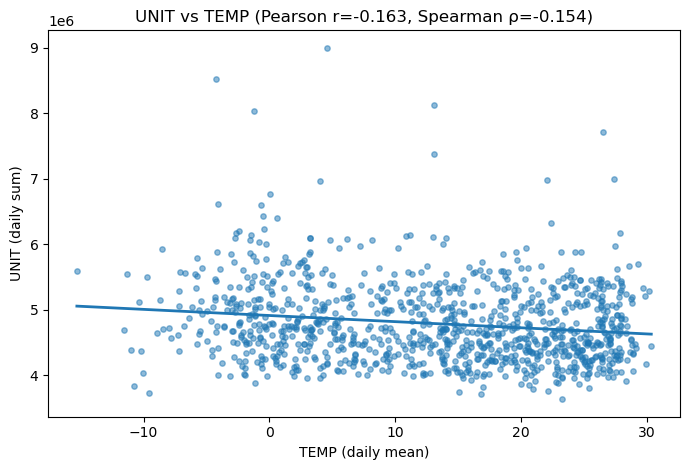

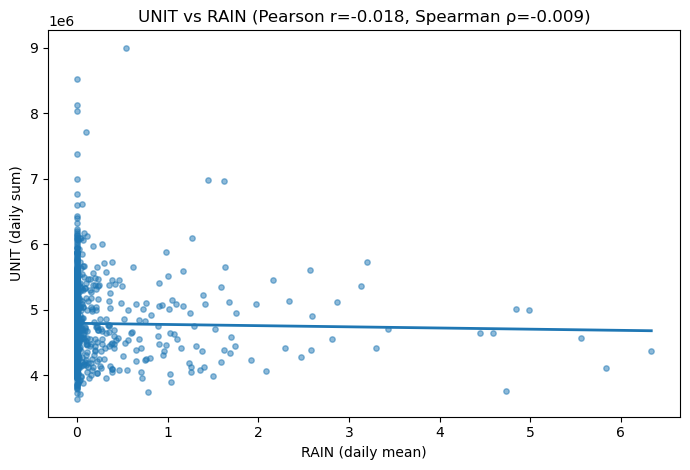


==== Holdout Evaluation (last 20%) ====
[ML] MAE=356,483.98 | RMSE=585,080.03
[DL] MAE=4,740,879.06 | RMSE=4,785,453.29

==== Predict by date ====

[입력 날짜에 사용된 (추정) TEMP/RAIN 포함 feature]
 dow  month  day  weekofyear  is_weekend  doy_sin  doy_cos      TEMP  RAIN
   6      1    1          52           1 0.017202 0.999852 -4.197485   0.0

예상 UNIT (ML) : 5,807,980
예상 UNIT (DL) : 7


In [5]:
# =========================================================
# 메인 실행
# =========================================================
if __name__ == "__main__":
    daily = load_and_make_daily(CSV_PATH)

    # 1) 상관관계 + 그래프
    corr_and_plots(daily)

    # 2) feature + climatology
    d = add_calendar_features(daily)
    clim = build_climatology(d)

    # 3) 모델 학습/평가
    ml_model, dl_model, feature_cols, train_data = train_models(d)

    # 4) 날짜 입력 예측
    predictor = build_predictor(train_data, clim, ml_model, dl_model, feature_cols)

    print("\n==== Predict by date ====")
    user_date = input("날짜 입력 (YYYY-MM-DD 또는 YYYYMMDD): ")
    pred_ml, pred_dl, used_x = predictor(user_date)

    print("\n[입력 날짜에 사용된 (추정) TEMP/RAIN 포함 feature]")
    print(used_x.to_string(index=False))

    print(f"\n예상 UNIT (ML) : {pred_ml:,.0f}")
    print(f"예상 UNIT (DL) : {pred_dl:,.0f}")

